In [1]:
import sys
sys.path.append('../')
from spreadpy.special_events import ChangeState
from spreadpy.basedesim import Event
import numpy as np
import spreadpy.parameters as params

params.VACCINE_STATES['rubella'] = {
        'not vaccinated': 0,
        'vaccinated': 1}


class RubellaSusceptibleToExposed(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'rubella', 'exposed')
        time = 0.5 + self.simulator.population.diseases['rubella'].stream.weibull(4.6)
        RubellaExposedToInfected(self.simulator.now() + time,
                                self.simulator, self.idx)


class RubellaSusceptibleToRecovered(ChangeState):

    def do(self):
        time = self.simulator.population.diseases['rubella'].stream.gamma(25, 10)
        self.simulator.population.change_state(self.idx, 'rubella', 'recovered')


class RubellaExposedToInfected(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'rubella',
                                               'infected')
        time = self.simulator.population.diseases['rubella'].stream.exponential(3)
        RubellaInfectedToRecovered(self.simulator.now() + time,
                                        self.simulator, self.idx)


class RubellaInfectedToRecovered(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'rubella', 'recovered')


class RubellaImportCases(Event):

    def __init__(self, time, simulator, cases=1):
        super().__init__(time, simulator)
        self.time = time
        self.simulator = simulator
        self.cases = cases

    def do(self):
        susceptibles = self.simulator.population.get_state(
            'rubella', 'susceptible')
        idx = self.simulator.population.diseases['rubella'].stream.choice(
            susceptibles, size=self.cases, replace=False)
        self.simulator.population.change_state(idx, 'rubella', 'infected')
        for person in idx:
            time = self.simulator.population.diseases['rubella'].stream.exponential(5)
            RubellaInfectedToRecovered(self.simulator.now() + time,
                                   self.simulator, person)


In [2]:
from spreadpy.disease import Disease

class Rubella(Disease):

    def __init__(self, simulator, attributes, stream):
        super().__init__('rubella', simulator, attributes, stream)
        self['states'] = {'susceptible': 0,
                          'exposed': 1,
                          'infected': 2,
                          'recovered': 3}
        self['contagious_states'] = [self['states']['infected']]
        self['infection_prob'] = attributes['infection_prob']
        RubellaImportCases(0, self.simulator, attributes['initial_cases'])

    def progression(self, population):
        susceptibles, probability = population.get_suceptible_prob(
            'rubella')
        exposed = susceptibles[np.where(
            self.stream.random(len(probability)) <= probability)]
        for person in exposed:
            RubellaSusceptibleToExposed(self.simulator.now(),
                                 self.simulator, person)

    def update_transmission(self, population, edge_seq, vertex_seq):
        '''
        Update transmission must consider all interventions
        '''
        # TODO: #1 determine which factors affect transmission (masking, quarantine, vaccination)
        def masking_prob(i, j):
            if i+j == 0:
                return 1
            elif i+j == 1:
                return 0.5
            else:
                return 0.3
        vfunc = np.vectorize(masking_prob)
        masking_p = vfunc(*population['masking'][vertex_seq].T)
        return masking_p*self['infection_prob']
    

In [3]:
from spreadpy.intervention import Intervention
import numpy as np

class RandomMasking(Intervention):
    '''docstring'''

    def do(self):
        if self.simulator.verbose:
            print('Masking intervention')
        idx = self.kwargs['stream'].choice(
            np.arange(self.simulator.population.size),
            size=int(self.kwargs['level']*self.simulator.population.size),
            replace=False)
        self.simulator.population['masking'] = np.zeros(self.simulator.population.size)
        self.simulator.population['masking'][idx] = 1
        self.simulator.population.update_transmission_weights()


In [4]:
from spreadpy.special_events import Step

class DailyStep(Step):
    ''' Disease progression '''
    STEP_SIZE = 1 # Daily time step

    def __init__(self, time, simulator):
        super().__init__(time, simulator)
        self.time = time
        self.simulator = simulator

    @classmethod
    def initialize(cls, simulator):
        for t in np.arange(0, int(simulator.stop_time)+1, DailyStep.STEP_SIZE):
            DailyStep(t, simulator)

    def do(self):
        if self.simulator.verbose:
            print('New day beginning {}'.format(self.time))
        for _, disease in self.simulator.population.diseases.items():
            disease.progression(self.simulator.population)

        # Stats collections here
        for i, name in zip(range(4),
                           ['S', 'E', 'I', 'R']):
            stat = len(
                np.where(self.simulator.population['rubella']['states'] == i)[0])
            self.simulator.collector.collect(name, stat)
        self.simulator.collector.collect(
            'masking', (self.simulator.population['masking'] == 1).sum())
        self.simulator.collector.collect(
            'states', self.simulator.population['rubella']['states'].copy())

In [13]:
import sys
sys.path.append('../')
import spreadpy as sp

#%%
if __name__ == '__main__':
    sim = sp.AgentBasedSim(DailyStep)

    # Create population
    pop_size = 100
    sim.create_population(
        how='basic',
        population_size=pop_size,
        network_seed=1024)


    # Create layers of network
    sim.add_layer(layer_name='community', how='erdos_renyi', n=pop_size, p=0.04)

    # Define disease
    sim.add_disease(Rubella,
                    disease_kwargs={'attributes':{'infection_prob': 0.12,
                                    'initial_cases': 5},
                                    'stream': sp.Stream(65347)})

    # Interventions
    sim.add_intervention(RandomMasking, 5, stream=sp.Stream(seed=1023),
        level= 0.5)
    sim.add_intervention(RandomMasking, 35, stream=sp.Stream(seed=1023),
        level= 0.0)

    # Run model
    sim.run(stop_time=100, verbose=False)  # Streams should be set when running the model


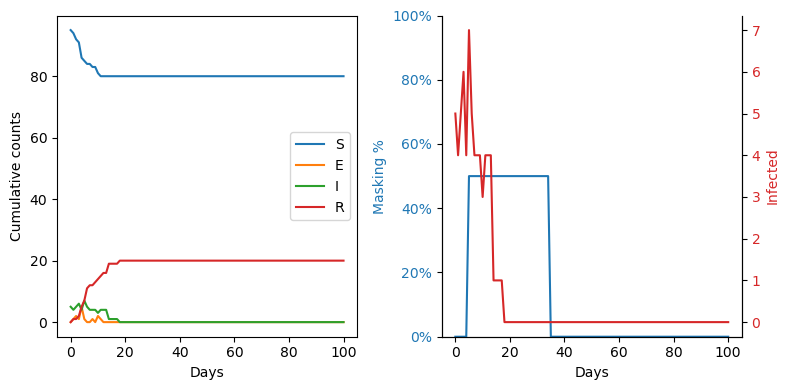

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(8, 4))
ax.plot(sim.collector['S'], label='S')
ax.plot(sim.collector['E'], label='E')
ax.plot(sim.collector['I'], label='I')
ax.plot(sim.collector['R'], label='R')
ax.set_ylabel('Cumulative counts')
ax.set_xlabel('Days')
ax.legend()

plt.ylim((0, 1))
color = 'tab:blue'
ax1.set_xlabel('Days')
ax1.set_ylabel('Masking %', color=color)
ax1.plot(sim.collector['masking']/pop_size, color=color, label='Masking')
ax1.tick_params(axis='y', labelcolor=color)
ax1.spines[['top']].set_visible(False)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Infected', color=color)  # we already handled the x-label with ax1
ax2.plot(sim.collector['I'], color=color)
ax2.spines[['top']].set_visible(False)
ax2.tick_params(axis='y', labelcolor=color)
plt.tight_layout()
plt.show()

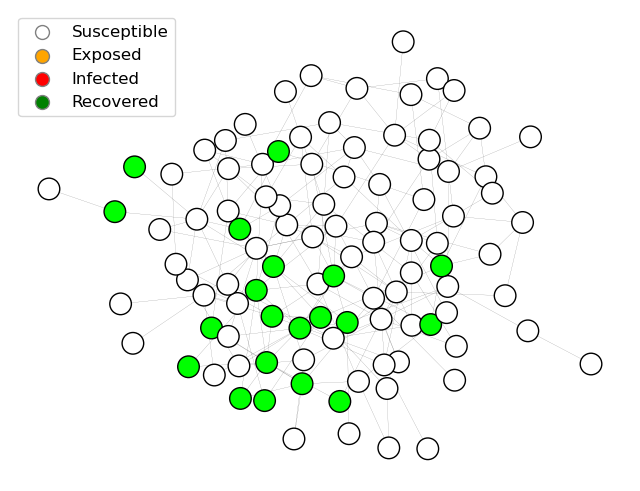

In [15]:
color_dict = {0: 'white', 1: 'orange', 2: 'red', 3: 'green'}
labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered']
colors = [color_dict[i] for i in sim.population['rubella']['states']]

fig, ax = plt.subplots(figsize=(8, 8))
sim.population.plot_network(ax, 'community', layout='kk',
                            vertex_color=colors, vertex_size=0.5, edge_width = 0.1)  # TODO: #15 Plotting function should be part of sim object
for i in [0, 1, 2, 3]:
    ax.scatter([], [], s=100, c=color_dict[i], edgecolor='gray',
                label=labels[i])
plt.legend(fontsize=12, loc='best')

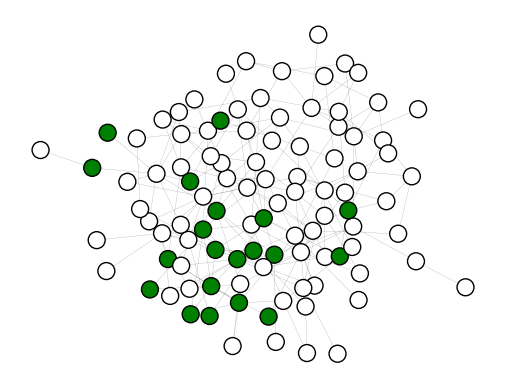

In [16]:
import matplotlib.animation as animation
import igraph as ig

def _update_graph(frame):
    for i in range(pop_size):
       graph_plot.patches[i].set_facecolor(colors[frame][i])
    return ax.get_children()

graph = sim.population.network['community'].graph
layout = graph.layout('kk')
colors = [[color_dict[i] for i in states] for states in sim.collector['states'].reshape(101, pop_size)]


fig, ax = plt.subplots()
graph_plot = ig.plot(graph,
    target=ax, layout=layout, vertex_color=colors[0],
    edge_width=0.1, vertex_size=0.5)

ani = animation.FuncAnimation(fig, _update_graph, 30, interval=500, blit=True)
ani.save('animation.gif', writer='pillow', fps=2)


In [113]:
plotter = ig.plot(graph,
        target=ax, layout=layout, vertex_color=colors[0],
        edge_width=0.1, vertex_size=0.5)

In [99]:
type(plotter)

matplotlib.axes._axes.Axes

matplotlib.collections.PathCollection

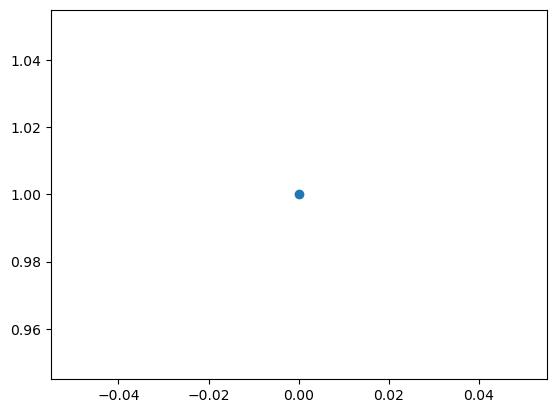

In [132]:
ww =plt.scatter(0,1)
type(ww)